# LFP, CSD

【注意】<br>
-LFPのみ、刺激種類ごとのグラフ出力<br>
-jsonファイルは場所から入力しなければいけない。<br>

In [1]:
import functions
import matplotlib.pyplot as plt
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import json

from scipy import interpolate
import scipy.ndimage as ndi

#### 1. .mat, .jsonファイル読み込み

In [2]:
root = tk.Tk()
root.withdraw()

mat_file = filedialog.askopenfilename(title="Open matlab file.", filetypes=[("matlab file", "*.mat")])

file_name = os.path.splitext(os.path.basename(mat_file))[0]

print(file_name)


In [4]:
mat= functions.load_mat(mat_file)

In [5]:
channel_kazu = 16
kinds_of_channel = 'WB'

### 2. チャンネル選択

In [6]:
samplerate = 40000
# magical_channel_data = [8,7,9,6,12,3,11,4,14,1,15,0,13,2,10,5]
magical_channel_data = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# magical_channel_data = [4,3,5,2,6,1,7,0,12,11,13,10,14,9,15,8,20,19,21,18,22,17,23,16]

data_all, N = functions.get_channel_data(mat, channel_kazu, kinds_of_channel, magical_channel_data)

# t = np.arange(0, N/samplerate, 1.0/samplerate)

print(data_all)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Oct 16 14:59:22 2023', '__version__': '1.0', '__globals__': [], 'AllFile': array([[  0.      , 137.085175]]), 'EVT01': array([[ 6.4373  ],
       [ 9.6605  ],
       [12.824575],
       [15.976475],
       [19.1299  ],
       [22.302925],
       [25.48485 ],
       [28.6962  ],
       [31.868625],
       [35.06975 ],
       [38.272625],
       [41.444525],
       [44.635725],
       [47.79625 ],
       [50.9481  ],
       [54.149525],
       [57.31055 ],
       [60.46185 ],
       [63.6931  ],
       [66.856775],
       [70.07845 ],
       [73.331425],
       [76.57315 ],
       [79.8048  ],
       [82.976275],
       [86.11785 ],
       [89.33885 ],
       [92.52125 ],
       [95.743225],
       [98.984425]]), 'Start': array([[0]], dtype=uint8), 'Stop': array([[137.085175]]), 'WB01': array([[ 0.20080566],
       [ 0.19897461],
       [ 0.20324707],
       ...,
       [-0.0177002 ],
       [-0.00823975],
       [-

In [7]:
event_gap_name = []
for i in range(channel_kazu):
        kazu_name = f'{i+1:02}'
        
        event_gap_name.append(kinds_of_channel + kazu_name + '_ts')

        if i == 0:
            event_gap_time = (mat[event_gap_name[i]])
            continue
        else:
            event_gap_time = np.vstack((event_gap_time, mat[event_gap_name[i]]))
print(event_gap_time)

for i in range(channel_kazu):
    if i == 0:
        event_gap = np.zeros(int(event_gap_time[i]*samplerate))
    else:
        event_gap = np.vstack((event_gap, np.zeros(int(event_gap_time[i]*samplerate))))

[[0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]
 [0.005175]]


for i in range(16):
    print(i)
    if i<8:
        a = data_all[i] - data_all[0]
    else:
        a = data_all[i] - data_all[8]

    if i==0:
        data_all_1 = a
    elif i==1:
        data_all_1 = np.array([data_all_1, a])
    else:
        data_all_1 = np.vstack((data_all_1, [a]))

### 3.　フィルタ

In [8]:
fp = 100 # 通過域端周波数[Hz]
fs = 400 # 阻止域端周波数[Hz]
filt_type = "low"        #high or low
filt_all = functions.lowpass(data_all, samplerate, fp, fs, filt_type, channel_kazu, event_gap)

filt_all = np.hstack((event_gap, filt_all))

print(filt_all)

### 5. イベントデータ取得

In [9]:
event_name = 'EVT01'
event = functions.load_event_data(mat, event_name)
print(event)
# event = event - event_gap_time[0]
# event

[[ 6.4373  ]
 [ 9.6605  ]
 [12.824575]
 [15.976475]
 [19.1299  ]
 [22.302925]
 [25.48485 ]
 [28.6962  ]
 [31.868625]
 [35.06975 ]
 [38.272625]
 [41.444525]
 [44.635725]
 [47.79625 ]
 [50.9481  ]
 [54.149525]
 [57.31055 ]
 [60.46185 ]
 [63.6931  ]
 [66.856775]
 [70.07845 ]
 [73.331425]
 [76.57315 ]
 [79.8048  ]
 [82.976275]
 [86.11785 ]
 [89.33885 ]
 [92.52125 ]
 [95.743225]
 [98.984425]]


In [12]:
from numpy import zeros

first_bias_edge = -0.4
next_bias_edge = 0

before_event = -0.04
after_event = 0.25

N_event = event.size
adjust = 1

each_event_response = zeros([channel_kazu, N_event, int((-before_event+after_event)*samplerate)+1+adjust])  #+1はt=0の時
print(f"each_event_response shape = {each_event_response.shape}")

for i, x in enumerate(event):
    first_bias = int((x + first_bias_edge)*samplerate)
    next_bias = int((x + next_bias_edge)*samplerate)

    first = int((x + before_event)*samplerate)
    last = int((x + after_event)*samplerate)

    for k in range(channel_kazu):
        j = 0
        #バイアス
        #bias = np.mean(data_all[k, first_bias:next_bias])
        # while first + j <= last:
        #     each_event_response[k, i, j] = data_all[k, first + j]-bias
        #     j += 1        
        while first + j <= last:
            each_event_response[k, i, j] = data_all[k, first + j]
            j += 1

each_event_response shape = (16, 30, 11602)


In [13]:
if adjust!=0:
    delete_num = list(range(-1, -(adjust+1), -1))
    g = np.delete(each_event_response, delete_num, axis=2)

In [18]:
#複数音刺激があるとき
# def each_sound_all_response(this_sound, sound_name, each_event_response, N_event):
#     from numpy import zeros

#     sound_num = [0,1,2,3,4,5]
#     for i in range(6):
#         if this_sound==sound_name[i]:
#             this_num = sound_num[i]
#     l1 = np.arange(N_event)
#     l2 = []
#     for x in l1:
#         if x%6 == this_num:
#             l2.append(x)

#     select_stim_each_event_response = each_event_response[:, l2]
#     return select_stim_each_event_response

In [20]:
#複数音刺激がある時
# sound_name = ['2kHz', '4kHz', '8kHz', '16kHz', '32kHz', 'click']

# this_sound = "16kHz"
# select_stim_each_event_response = each_sound_all_response(this_sound, sound_name, each_event_response, N_event)
# select_stim_mean_response = np.mean(select_stim_each_event_response, axis=1)

In [20]:
mean = np.mean(each_event_response, axis=1)

In [34]:
import matplotlib.pyplot as plt
from matplotlib import patches

def lfp_1_32(ax, channel, t, ave_all, y_axis):

    ax.plot(t, ave_all[channel], clip_on=False, color = "black", linewidth=2)

    # if channel==0 or channel==8 or channel==16:    
    #     r = patches.Rectangle( (0,0.09) , 100, 0.02, fill=True, color="black", linewidth=3, label="rectangle")
    #     ax.add_patch(r)

        # ax.scatter(0,y_axis+0.01, c='black', s=500, marker="v", clip_on=False)

#    ax.set_xlim(-10, 100)
    ax.set_ylim(-y_axis, y_axis)
    # ax.set_xlim(-x_axis_before, x_axis_after)
    # ax.set_yticks([0], fontsize=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.tick_params(labelbottom=False, labelright=False, labelleft=False, bottom=False, right=False,length=6, left=False)
    ax.axhline(y=0, linestyle="dotted",color="gainsboro")
    # ax.axvline(x=15, linewidth=3, color='red')
    # ax.set_ylabel(channel*100, rotation=360, labelpad=22, fontsize=16,va='center')
    # else:
    #     ax.set_ylabel((channel-8)*100, rotation=360, labelpad=22, fontsize=16,va='center')
    ax.tick_params(left=True)
    # 背景色透過
    ax.set_facecolor("#fff0")

In [21]:
mean.shape

(16, 11602)

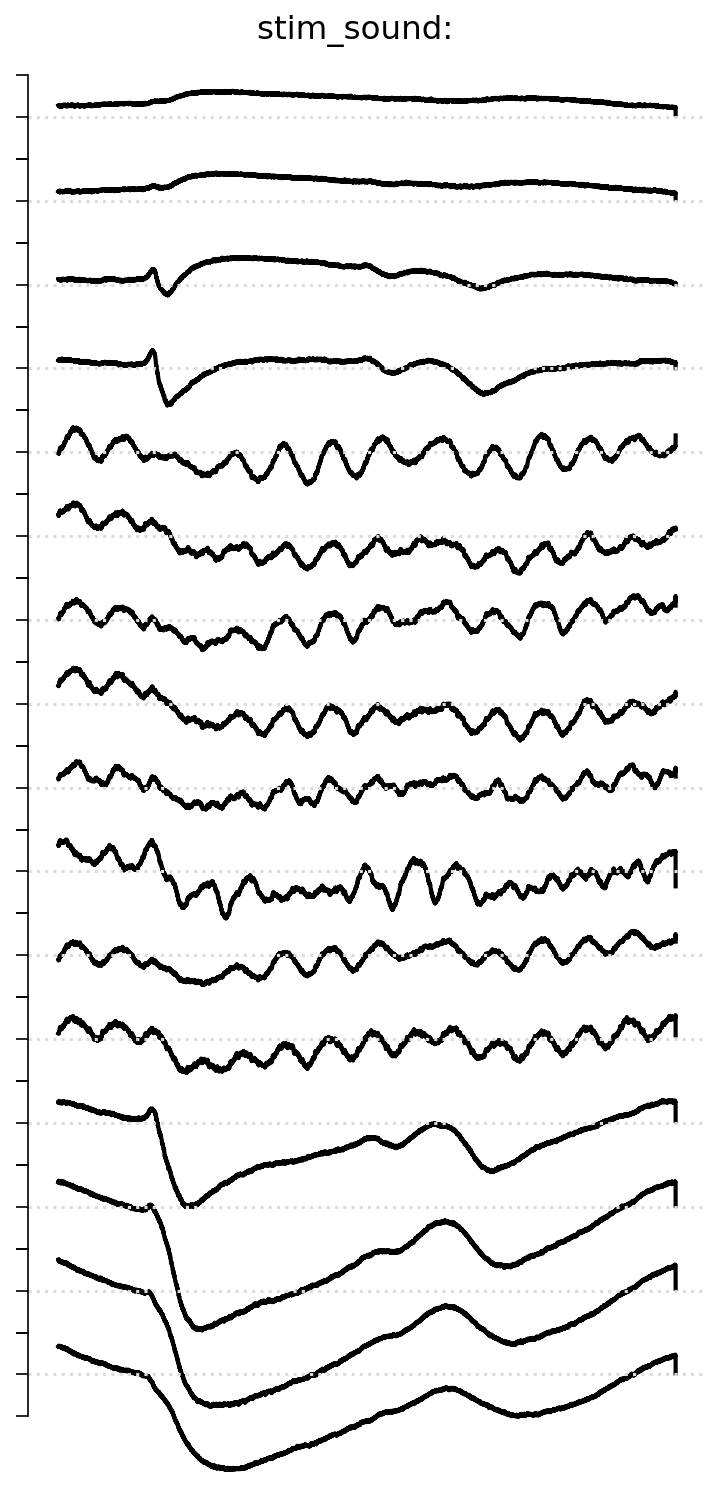

In [35]:
y_axis = 0.1
t = (np.arange(len(mean[0]))/40000+before_event)*1000

fig, axes = plt.subplots(16, 1, figsize=(5,10), dpi=150)
lfp_1_32(axes[0], 0, t, mean, y_axis)
lfp_1_32(axes[1], 1, t, mean, y_axis)
lfp_1_32(axes[2], 2, t, mean, y_axis)
lfp_1_32(axes[3], 3, t, mean, y_axis)
lfp_1_32(axes[4], 4, t, mean, y_axis)
lfp_1_32(axes[5], 5, t, mean, y_axis)
lfp_1_32(axes[6], 6, t, mean, y_axis)
lfp_1_32(axes[7], 7, t, mean, y_axis)

lfp_1_32(axes[8], 8, t, mean, y_axis)
lfp_1_32(axes[9], 9, t, mean, y_axis)
lfp_1_32(axes[10], 10, t, mean, y_axis)
lfp_1_32(axes[11], 11, t, mean, y_axis)
lfp_1_32(axes[12], 12, t, mean, y_axis)
lfp_1_32(axes[13], 13, t, mean, y_axis)
lfp_1_32(axes[14], 14, t, mean, y_axis)
lfp_1_32(axes[15], 15, t, mean, y_axis)


plt.suptitle("stim_sound: "+"")
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)
#plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
plt.rcParams['font.size'] = 13

plt.show()

In [27]:
from scipy import interpolate

# #１シャンクのLFPを抽出
# list_lfp_11 = []
# for i in range(8):
#     list_lfp_11.append(select_stim_mean_response[i])

#二回微分を行う
# csd_1 = - 0.3 * np.gradient(np.gradient(list_lfp_11, axis=0), axis=0) / 0.05**2
csd_1 = - 0.3 * np.gradient(np.gradient(mean, axis=0), axis=0) / 0.05**2

#各データ点の深さ
x1 = np.linspace(100, 800, 8)
print(x1)
#各深さの間を補完した関数を作成
x = np.arange(len(csd_1))
csd_mesh_1 = interpolate.interp1d(x, csd_1, axis=0)

#深さについても，サンプルレートを多くする．
X = np.linspace(0,x[-1],(x.size - 1) * 100 + 1)
#csd = -0.3 * np.gradient(np.gradient(ave_all, axis=0), axis=0)/(0.05**2)
print(X)

[100. 200. 300. 400. 500. 600. 700. 800.]
[0.000e+00 1.000e-02 2.000e-02 ... 1.498e+01 1.499e+01 1.500e+01]


In [26]:
#一つのシャンクのみを見たい時用

# y_axis = 0.1
# t = (np.arange(len(select_stim_mean_response[0]))/40000+before_event)*1000

# fig, axes = plt.subplots(8, 1, figsize=(10, 5), dpi=150)
# lfp_1_32(axes[0], 0, t, select_stim_mean_response, y_axis)
# lfp_1_32(axes[1], 1, t, select_stim_mean_response, y_axis)
# lfp_1_32(axes[2], 2, t, select_stim_mean_response, y_axis)
# lfp_1_32(axes[3], 3, t, select_stim_mean_response, y_axis)
# lfp_1_32(axes[4], 4, t, select_stim_mean_response, y_axis)
# lfp_1_32(axes[5], 5, t, select_stim_mean_response, y_axis)
# lfp_1_32(axes[6], 6, t, select_stim_mean_response, y_axis)
# lfp_1_32(axes[7], 7, t, select_stim_mean_response, y_axis)

# plt.suptitle("stim_sound: "+this_sound)
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.1, hspace=0)
# #plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
# plt.rcParams['font.size'] = 13

# if save == 1:
#     save_fol = save_folder_name + file_name + "_LFP_" + this_sound + ".jpg"
#     plt.savefig(save_fol) 

# plt.show()

In [28]:
# import scipy.ndimage as ndi
#平均化フィルタ（縦・横同じサイズ）
# csd_1 = ndi.uniform_filter(csd_mesh_1(X), size=10)
csd = np.array([
    np.convolve(data, np.ones(300), mode='valid')
    for data in csd_mesh_1(X)
])/300
csd.shape

(1501, 11303)

In [28]:
# t_1 = np.convolve(t,np.ones(5), mode='valid') / 5

In [29]:
x = np.linspace(-0.04, 0.25, len(csd[0]))
y = np.linspace(100, 800, len(csd))
X, Y = np.meshgrid(x, y[::-1])
# divnorm = mcl.TwoSlopeNorm(vcenter=0, vmin=settings.ylim[0], vmax=settings.ylim[1])

<function matplotlib.pyplot.show(close=None, block=None)>

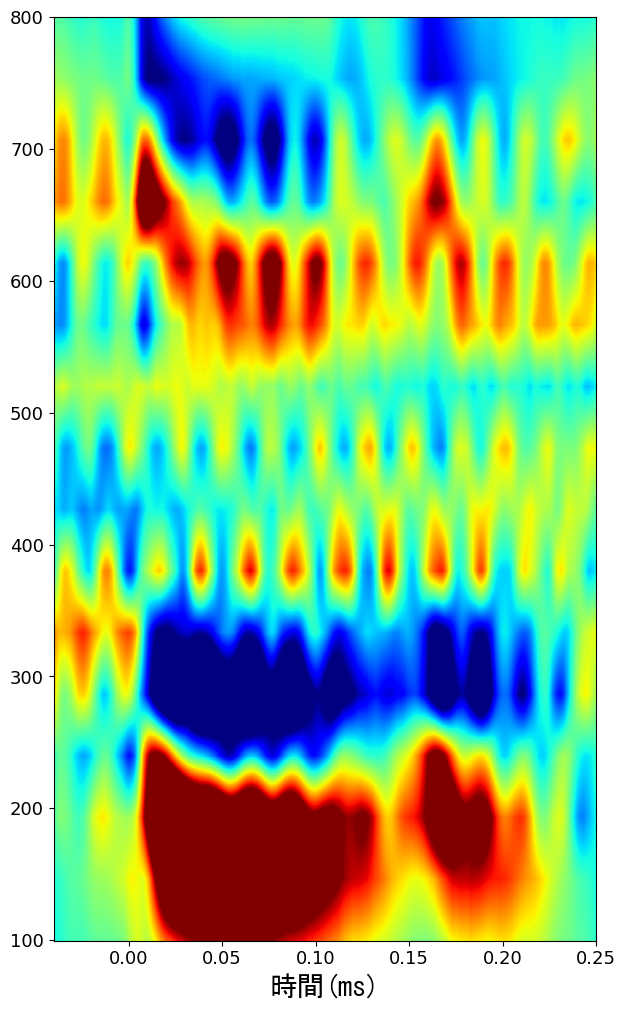

In [31]:
plt.pcolormesh(X, Y, -csd, cmap="jet", shading="auto", rasterized=True)
max = 3
min = -3
plt.clim(min,max)
# plt.ylim(800, 100)
# plt.yticks(fontsize=18)
# plt.xticks([0,100,200], fontsize=18)
plt.xlabel("時間(ms)", fontname="MS Gothic", fontsize=20)
plt.rcParams['figure.figsize'] = (7, 12)

plt.show